In [62]:
# Import packages
import os
import time
import tensorflow as tf

# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

# Import Remaining Packages (Post-Install)
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.sql.functions import col, count

#import for visualizations
import pyspark as ps
import matplotlib
import numpy as np
import matplotlib.pyplot as plt  # To visualize
import pandas as pd  # To read data
from sklearn.linear_model import LinearRegression

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done


In [2]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [4]:
#connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Spark DataFrames

In [5]:
# double check to make sure your pathway to the csv's is the same!!!!

#read in the csv data from google drive
spark.sparkContext.addFile('/content/gdrive/MyDrive/Project4/Data/train_timeseries.csv')
train_timeseries_df = spark.read.csv(SparkFiles.get('/content/gdrive/MyDrive/Project4/Data/train_timeseries.csv'), sep=",", header=True, inferSchema=True)

spark.sparkContext.addFile('/content/gdrive/MyDrive/Project4/Data/test_timeseries.csv')
test_timeseries_df = spark.read.csv(SparkFiles.get('/content/gdrive/MyDrive/Project4/Data/test_timeseries.csv'), sep=",", header=True, inferSchema=True)

spark.sparkContext.addFile('/content/gdrive/MyDrive/Project4/Data/validation_timeseries.csv')
validation_timeseries_df = spark.read.csv(SparkFiles.get('/content/gdrive/MyDrive/Project4/Data/validation_timeseries.csv'), sep=",", header=True, inferSchema=True)

spark.sparkContext.addFile('/content/gdrive/MyDrive/Project4/Data/soil_data.csv')
soil_data_df = spark.read.csv(SparkFiles.get('/content/gdrive/MyDrive/Project4/Data/soil_data.csv'), sep=",", header=True, inferSchema=True)

In [6]:
train_timeseries_df.show(20)

+----+----------+-------+------+-----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|fips|      date|PRECTOT|    PS| QV2M|  T2M|T2MDEW|T2MWET|T2M_MAX|T2M_MIN|T2M_RANGE|   TS|WS10M|WS10M_MAX|WS10M_MIN|WS10M_RANGE|WS50M|WS50M_MAX|WS50M_MIN|WS50M_RANGE|score|
+----+----------+-------+------+-----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|1001|2000-01-01|   0.22|100.51| 9.65|14.74| 13.51| 13.51|  20.96|  11.46|      9.5|14.65|  2.2|     2.94|     1.49|       1.46| 4.85|     6.04|     3.23|       2.81| null|
|1001|2000-01-02|    0.2|100.55|10.42|16.69| 14.71| 14.71|   22.8|  12.61|    10.18| 16.6| 2.52|     3.43|     1.83|        1.6| 5.33|     6.13|     3.72|       2.41| null|
|1001|2000-01-03|   3.65|100.15|11.76|18.49| 16.52| 16.52|  22.73|  15.32|     7.41|18.41| 4.03|     5.33|     2.66|       2.67| 7.53| 

In [7]:
test_timeseries_df.show()

+----+----------+-------+------+----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|fips|      date|PRECTOT|    PS|QV2M|  T2M|T2MDEW|T2MWET|T2M_MAX|T2M_MIN|T2M_RANGE|   TS|WS10M|WS10M_MAX|WS10M_MIN|WS10M_RANGE|WS50M|WS50M_MAX|WS50M_MIN|WS50M_RANGE|score|
+----+----------+-------+------+----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|1001|2019-01-01|   2.25|100.51|9.69|14.71| 13.55| 13.52|  17.38|  10.92|     6.46|14.63|  1.2|      1.5|     0.79|       0.71| 2.74|     4.01|     1.23|       2.78|  0.0|
|1001|2019-01-02|   4.94|100.48|8.65|13.05| 11.83| 11.74|  17.76|   9.54|     8.23|13.06| 1.02|     1.35|     0.32|       1.03| 2.13|     3.37|     0.56|       2.81| null|
|1001|2019-01-03|  20.74|100.03|8.59|12.12| 11.67| 11.67|  13.74|  10.44|      3.3|12.12| 1.83|     4.23|     0.34|       3.88| 3.41|     7.

In [8]:
validation_timeseries_df.show(50)

+----+----------+-------+------+-----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|fips|      date|PRECTOT|    PS| QV2M|  T2M|T2MDEW|T2MWET|T2M_MAX|T2M_MIN|T2M_RANGE|   TS|WS10M|WS10M_MAX|WS10M_MIN|WS10M_RANGE|WS50M|WS50M_MAX|WS50M_MIN|WS50M_RANGE|score|
+----+----------+-------+------+-----+-----+------+------+-------+-------+---------+-----+-----+---------+---------+-----------+-----+---------+---------+-----------+-----+
|1001|2017-01-01|   32.5|100.02|10.47|14.69| 14.47| 14.47|  17.68|  10.53|     7.15|14.63| 2.14|     2.71|     1.52|       1.19|  4.4|     5.96|     2.25|       3.71| null|
|1001|2017-01-02|  63.52|100.04|12.75|17.96| 17.75| 17.75|   20.3|  16.14|     4.16|17.85| 2.75|     4.31|      1.6|       2.71|  5.5|     8.16|     4.05|       4.11| null|
|1001|2017-01-03|  18.82| 99.69| 9.74|14.24| 13.44| 13.44|  18.48|   9.29|      9.2|14.06| 2.25|     3.73|     1.64|       2.09|  4.8| 

In [9]:
soil_data_df.show()

+----+---------+----------+---------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+-------------------+-------------------+---+---+---+---+---+---+---+
|fips|      lat|       lon|elevation|slope1|slope2|slope3|slope4|slope5|slope6|slope7|slope8|aspectN|aspectE|aspectS|aspectW|aspectUnknown|         WAT_LAND|        NVG_LAND|         URB_LAND|         GRS_LAND|        FOR_LAND|      CULTRF_LAND|        CULTIR_LAND|          CULT_LAND|SQ1|SQ2|SQ3|SQ4|SQ5|SQ6|SQ7|
+----+---------+----------+---------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+-------------------+-------------------+---+---+---+---+---+---+---+
|1001|32.536382| -86.64449|       63|0.0419|0.2788|0.2984|

In [10]:
# combine dataframes
df = train_timeseries_df.union(validation_timeseries_df).union(test_timeseries_df)

In [11]:
#count the rows of the combined dataframe
df.count()

23841468

In [12]:
#Parquet the joined dataframes
df.write.parquet('parquet_timeseries', mode='overwrite')

In [13]:
#read parquet data
p_df=spark.read.parquet('parquet_timeseries')

In [14]:
#confirm parquet was successful
p_df.count()

23841468

## GeoCode to get States

In [15]:
import pyspark.sql.functions as F
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geotrack")

In [17]:
column_names = soil_data_df.columns

In [20]:
# ran once to collect the states
# commented out to not re-run since it take over 30 minutes


# for i,row in df.iterrows():

#   latitude = row['lat']
#   longitude = row['lon']

#   coord = f'{latitude}, {longitude}'

#   try:
#     location = geolocator.reverse(coord, language='en').raw['address']['state']
#     df.loc[i,'state'] = location
#     print(i, location)
#   except:
#     df.loc[i,'state'] = 'Unknown'
#     print(i)

In [21]:
# saved with state data
# df.to_csv('/content/gdrive/MyDrive/Project4/Data/state_soil.csv')
state_df = pd.read_csv('/content/gdrive/MyDrive/Project4/Data/state_soil.csv')

In [22]:
state_df['state'].value_counts()[:20]

Texas             254
Georgia           159
Virginia          134
Kentucky          120
Missouri          115
Kansas            105
Illinois          102
North Carolina    100
Iowa               99
Tennessee          95
Nebraska           93
Indiana            92
Ohio               88
Minnesota          87
Michigan           83
Mississippi        82
Oklahoma           77
Arkansas           75
Wisconsin          72
Florida            67
Name: state, dtype: int64

In [23]:
#dropping null values
p_df.na.drop().count()

3406368

In [24]:
# converting soil data back to Spark DF
state_soil_df = spark.createDataFrame(state_df)

In [25]:
state_soil_df.show()

+----------+----+---------+----------+---------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+------------------+------------------+---+---+---+---+---+---+---+-------+
|Unnamed: 0|fips|      lat|       lon|elevation|slope1|slope2|slope3|slope4|slope5|slope6|slope7|slope8|aspectN|aspectE|aspectS|aspectW|aspectUnknown|         WAT_LAND|        NVG_LAND|         URB_LAND|         GRS_LAND|        FOR_LAND|      CULTRF_LAND|       CULTIR_LAND|         CULT_LAND|SQ1|SQ2|SQ3|SQ4|SQ5|SQ6|SQ7|  state|
+----------+----+---------+----------+---------+------+------+------+------+------+------+------+------+-------+-------+-------+-------+-------------+-----------------+----------------+-----------------+-----------------+----------------+-----------------+------------------+------------------+---+---+---+---+---+---+---+-------+
|      

In [26]:
# Join DataFrames
p_df.join(state_soil_df,'fips',"left").na.drop().createOrReplaceTempView('data_table')

In [27]:
# parquet DataFrame
p_df.join(state_soil_df,'fips',"left").na.drop().write.parquet('parquet_data', mode='overwrite')

In [28]:
# Read the parquet formatted data.
merge_df=spark.read.parquet('parquet_data')

In [29]:
# Create a temporary table for the parquet data.
merge_df.createOrReplaceTempView('merge_data')

## Soil Linear Regression

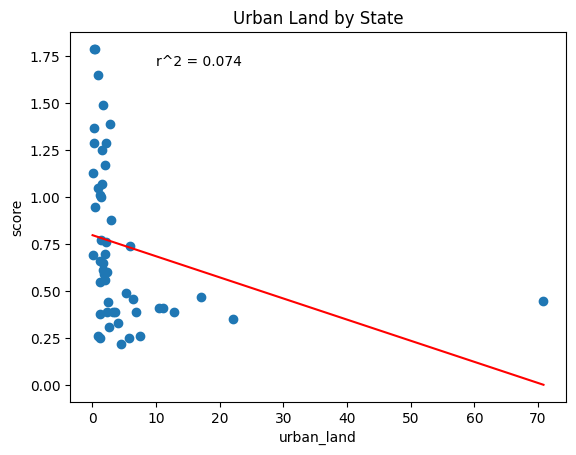

In [114]:
# Urban Land
urban_land_df = spark.sql("""
  SELECT state, ROUND(AVG(URB_LAND),2) as urban_land, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY urban_land DESC
  """)

urban_land_df = urban_land_df.toPandas()
urban_land_df.plot.scatter(x='urban_land', y='score', title='Urban Land by State')
X = urban_land_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = urban_land_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (10, 1.7))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/urban.png")
plt.show()

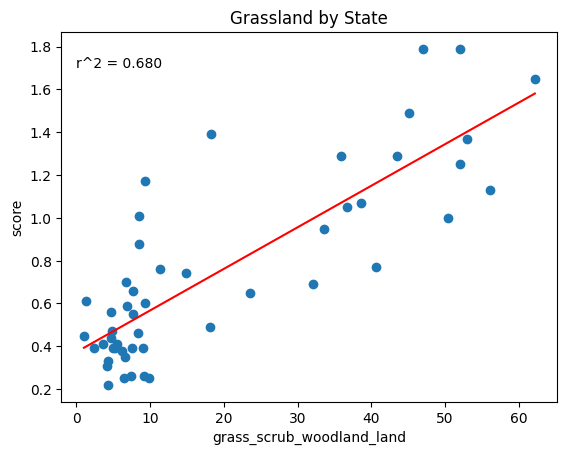

In [110]:
# Grass Land
grass_land_df = spark.sql("""
  SELECT state, ROUND(AVG(GRS_LAND),2) as grass_scrub_woodland_land, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY grass_scrub_woodland_land DESC
  """)

grass_land_df = grass_land_df.toPandas()
grass_land_df.plot.scatter(x='grass_scrub_woodland_land', y='score', title='Grassland by State')

X = grass_land_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = grass_land_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (0, 1.7))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/grassland.png")
plt.show()


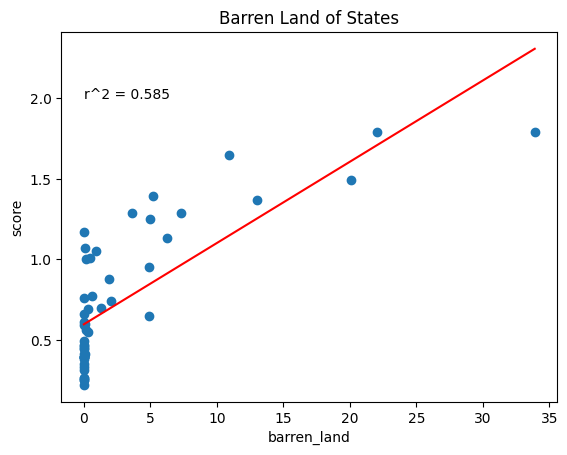

In [116]:
# barren Land
bare_land_df = spark.sql("""
  SELECT state, ROUND(AVG(NVG_LAND),2) as barren_land, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY barren_land DESC
  """)

bare_land_df = bare_land_df.toPandas()
bare_land_df.plot.scatter(x='barren_land', y='score', title='Barren Land of States')

X = bare_land_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = bare_land_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (0, 2))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/barren.png")

plt.show()

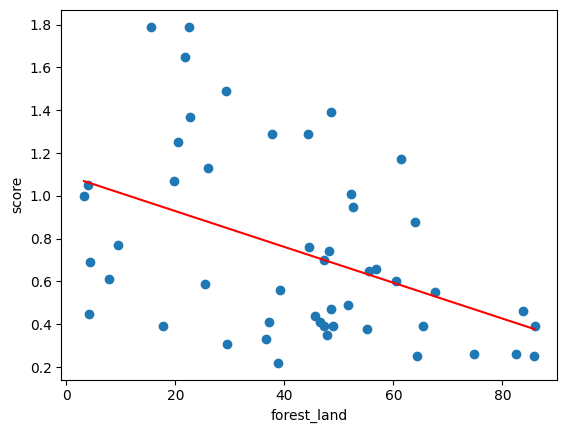

0.18802950642118277


In [74]:
# forest Land
for_land_df = spark.sql("""
  SELECT state, ROUND(AVG(FOR_LAND),2) as forest_land, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY forest_land DESC
  """)

for_land_df = for_land_df.toPandas()
for_land_df.plot.scatter(x='forest_land', y='score')

X = for_land_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = for_land_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

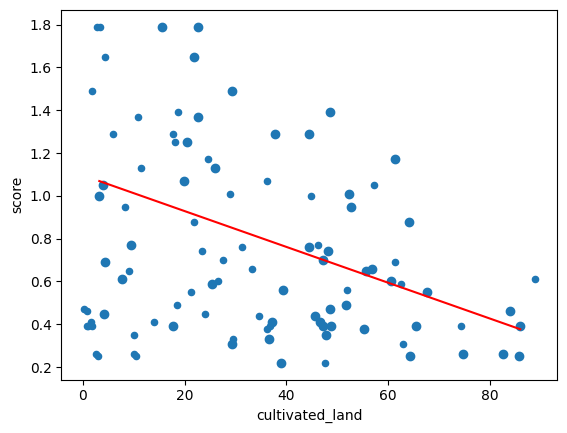

0.18802950642118277


In [75]:
# cultivated Land
cult_land_df =spark.sql("""
  SELECT state, ROUND(AVG(CULT_LAND),2) as cultivated_land, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY cultivated_land DESC
  """)

cult_land_df =cult_land_df.toPandas()
cult_land_df.plot.scatter(x='cultivated_land', y='score')

X = for_land_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = for_land_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

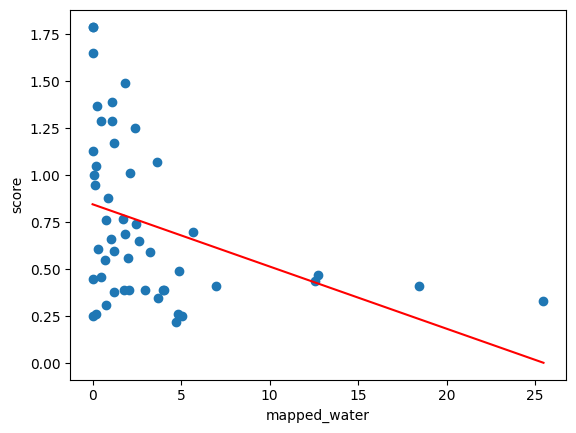

0.13443265516431602


In [76]:
# mapped water bodies
mapped_water_df = spark.sql("""
  SELECT state, ROUND(AVG(WAT_LAND),2) as mapped_water, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY mapped_water DESC
  """)

mapped_water_df = mapped_water_df.toPandas()
mapped_water_df.plot.scatter(x='mapped_water', y='score')

X = mapped_water_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = mapped_water_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

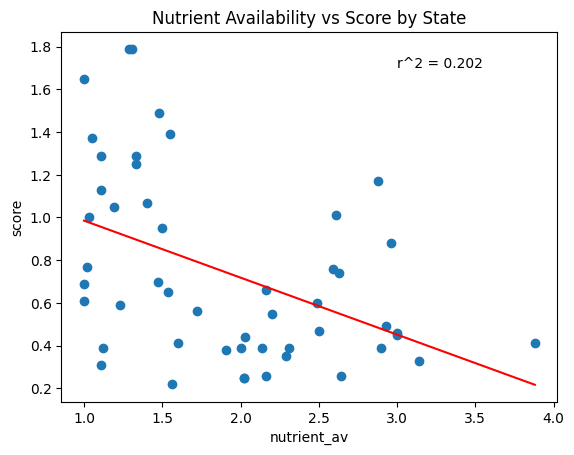

In [121]:
# nutrient availability
nutrient_av_df = spark.sql("""
  SELECT state, ROUND(AVG(SQ1),2) as nutrient_av, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY nutrient_av DESC
  """)

nutrient_av_df = nutrient_av_df.toPandas()
nutrient_av_df.plot.scatter(x='nutrient_av', y='score', title='Nutrient Availability vs Score by State')

X = nutrient_av_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = nutrient_av_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (3.0, 1.7))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/nutrient_avail.png")
plt.show()

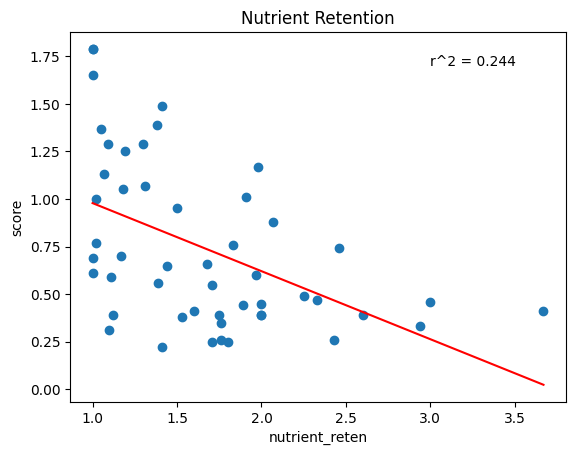

In [123]:
# nutrient retention capacity
nutrient_reten_df = spark.sql("""
  SELECT state, ROUND(AVG(SQ2),2) as nutrient_reten, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY nutrient_reten DESC
  """)

nutrient_reten_df = nutrient_reten_df.toPandas()
nutrient_reten_df.plot.scatter(x='nutrient_reten', y='score',title='Nutrient Retention')

X = nutrient_reten_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = nutrient_reten_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (3.0, 1.7))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/nutrient_ret.png")
plt.show()

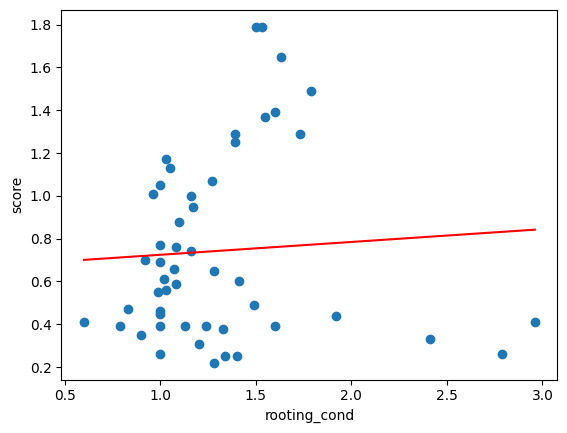

0.00396547271189962


In [80]:
# rooting conditions
rooting_cond_df = spark.sql("""
  SELECT state, ROUND(AVG(SQ3),2) as rooting_cond, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY rooting_cond DESC
  """)

rooting_cond_df = rooting_cond_df.toPandas()
rooting_cond_df.plot.scatter(x='rooting_cond', y='score')

X = rooting_cond_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = rooting_cond_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

<Axes: xlabel='oxy_aval', ylabel='score'>

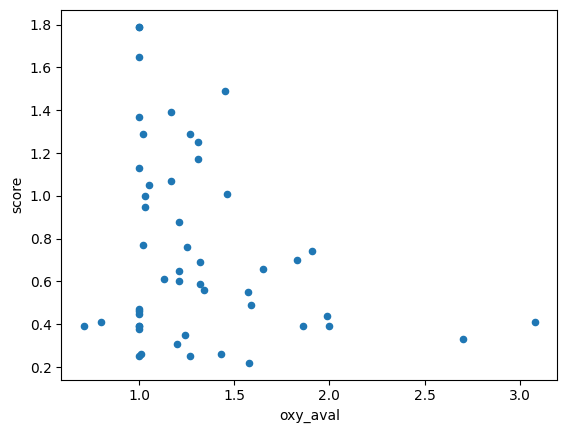

In [124]:
# oxygen availability
oxy_aval_df = spark.sql("""
  SELECT state, ROUND(AVG(SQ4),2) as oxy_aval, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY oxy_aval DESC
  """)

oxy_aval_df = oxy_aval_df.toPandas()
oxy_aval_df.plot.scatter(x='oxy_aval', y='score')

## Time series linear regression

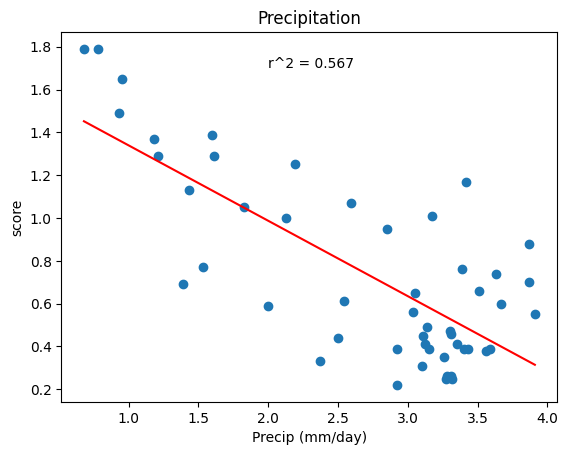

In [144]:
# precipitation
precip_df = spark.sql("""
  SELECT state, ROUND(AVG(PRECTOT),2) as precip, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY precip DESC
  """)

precip_df = precip_df.toPandas()
precip_df.plot.scatter(x='precip', y='score',title='Precipitation', xlabel='Precip (mm/day)')

X = precip_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = precip_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (2, 1.7))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/precip.png")

plt.show()

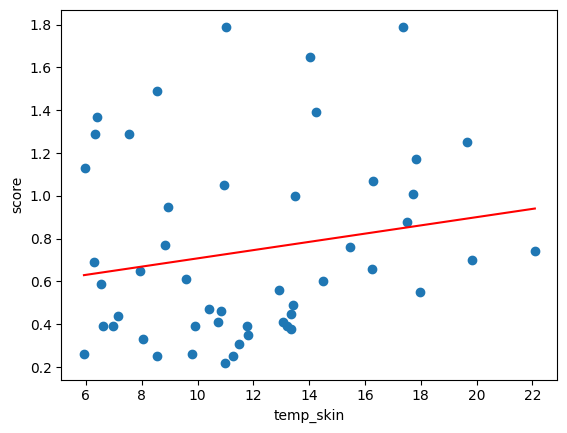

0.03427858342663803


In [154]:
# earth skin temp
temp_skin_df = spark.sql("""
  SELECT state, ROUND(AVG(TS),2) as temp_skin, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY temp_skin DESC
  """)

temp_skin_df = temp_skin_df.toPandas()
temp_skin_df.plot.scatter(x='temp_skin', y='score')

X = temp_skin_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = temp_skin_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

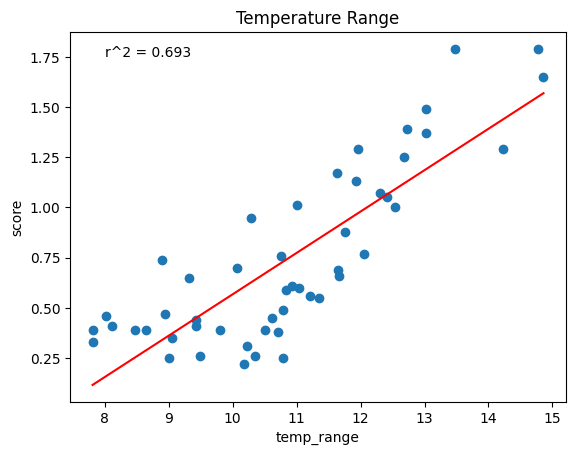

In [156]:
# T2M_RANGE
temp_range_df = spark.sql("""
  SELECT state, ROUND(AVG(T2M_RANGE),2) as temp_range, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY temp_range DESC
  """)

temp_range_df = temp_range_df.toPandas()
temp_range_df.plot.scatter(x='temp_range', y='score', title='Temperature Range')

X = temp_range_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = temp_range_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (8, 1.75))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/temp_range.png")

plt.show()

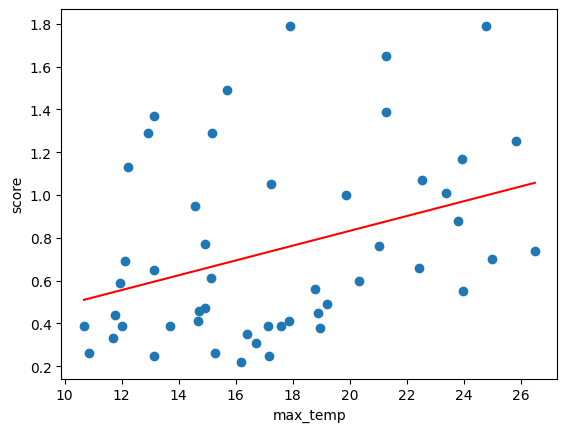

0.12401240029426852


In [152]:
# T2M_MAX
max_temp_df = spark.sql("""
  SELECT state, ROUND(AVG(T2M_MAX),2) as max_temp, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY max_temp DESC
  """)

max_temp_df = max_temp_df.toPandas()
max_temp_df.plot.scatter(x='max_temp', y='score')

X = max_temp_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = max_temp_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')
plt.show()

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
print(r_squared)

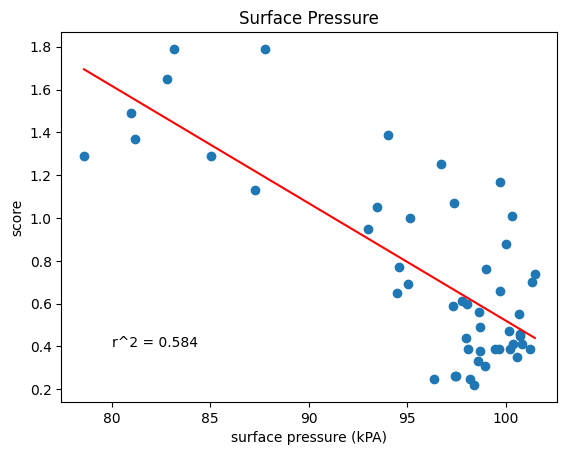

In [145]:
# surface pressure
wind_10m_df = spark.sql("""
  SELECT state, ROUND(AVG(PS),2) as pressure, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY state
  ORDER BY pressure DESC
  """)

wind_10m_df = wind_10m_df.toPandas()
wind_10m_df.plot.scatter(x='pressure', y='score',title='Surface Pressure',xlabel='surface pressure (kPA)')

X = wind_10m_df.iloc[:, 1].values.reshape(-1, 1)  # values converts it into a numpy array
Y = wind_10m_df.iloc[:, 2].values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
plt.scatter(X, Y)
plt.plot(X, Y_pred, color='red')

# linear regression
model = LinearRegression()
model.fit(X, Y)
r_squared = model.score(X, Y)
plt.annotate("r^2 = {:.3f}".format(r_squared), (80, .4))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/pressure.png")

plt.show()

## Time Series for Score

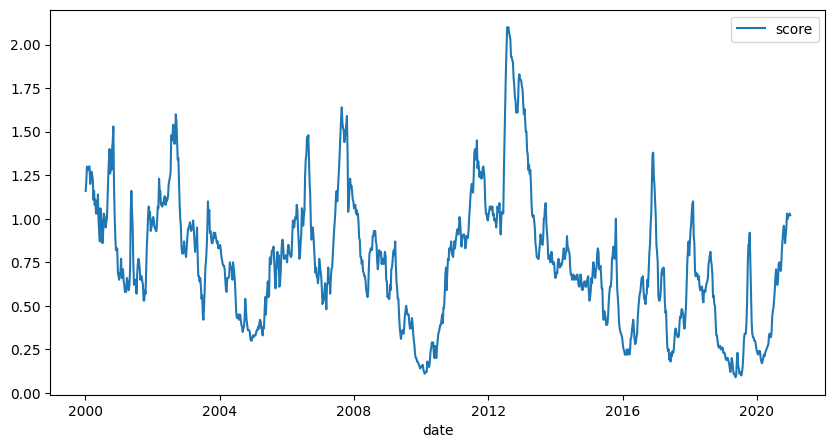

In [146]:
# drought over time
score_line_df = spark.sql("""
  SELECT date, ROUND(AVG(score),2) as score
  FROM merge_data
  GROUP BY date
  ORDER BY score DESC
  """)

score_line_df = score_line_df.toPandas()
score_line_df.plot.line(x='date', y='score', figsize=(10,5))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/drought_timeseries.png")

In [47]:
# temp at 2 meters
texas_line_df = spark.sql("""
  SELECT state, date, ROUND(AVG(score),2) as score
  FROM merge_data
  WHERE state='Texas'
  GROUP BY state, date
  ORDER BY date DESC
  """)

cal_line_df = spark.sql("""
  SELECT state, date, ROUND(AVG(score),2) as score
  FROM merge_data
  WHERE state='California'
  GROUP BY state, date
  ORDER BY date DESC
  """)

al_line_df = spark.sql("""
  SELECT state, date, ROUND(AVG(score),2) as score
  FROM merge_data
  WHERE state='Alabama'
  GROUP BY state, date
  ORDER BY date DESC
  """)

texas_line_df = texas_line_df.toPandas()
cal_line_df = cal_line_df.toPandas()
al_line_df = al_line_df.toPandas()
# score_line_df.plot.line(x='date', y='score')

In [48]:
texas_line_df.rename(columns={'score':'Texas'},inplace=True)
texas_line_df=texas_line_df.drop(['state'],axis=1)

cal_line_df.rename(columns={'score':'California'},inplace=True)
cal_line_df=cal_line_df.drop(['state'],axis=1)

al_line_df.rename(columns={'score':'Alabama'},inplace=True)
al_line_df=al_line_df.drop(['state'],axis=1)

In [49]:
state_score_df =pd.merge(texas_line_df,cal_line_df, on='date', how='left')
state_score_df = state_score_df.merge(al_line_df,on='date',how='left')
state_score_df

,date,Texas,California,Alabama
0,2020-12-29,2.40,2.98,0.07
1,2020-12-22,2.39,2.98,0.23
2,2020-12-15,2.36,2.98,0.23
3,2020-12-08,2.35,2.93,0.16
4,2020-12-01,2.34,2.58,0.10
...,...,...,...,...
1091,2000-02-01,2.32,0.25,1.54
1092,2000-01-25,2.23,0.31,1.87
1093,2000-01-18,2.23,0.61,1.86
1094,2000-01-11,2.23,0.76,1.87


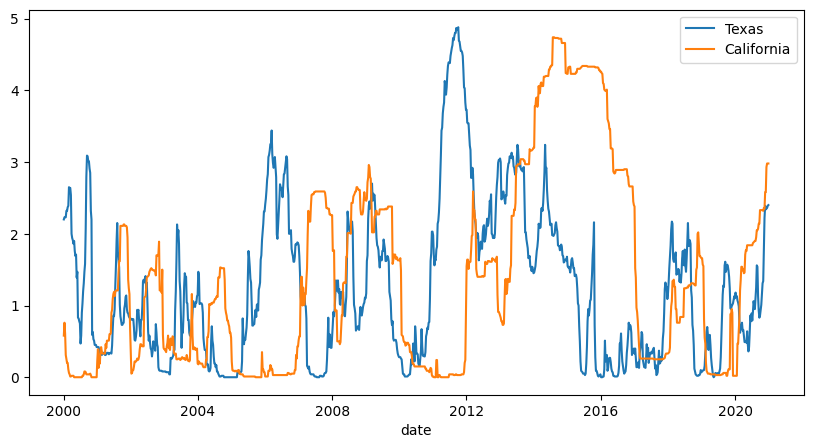

In [147]:
state_score_df.plot.line(x='date', y=['Texas','California'], figsize=(10,5))
plt.savefig("/content/drive/MyDrive/Project4/Plot PNGs/state_timeseries.png")

## Elevation Description

In [51]:
# Elevation
elevation_df = spark.sql("""
  SELECT fips, ROUND(AVG(elevation),2) as elevation
  FROM merge_data
  GROUP BY fips
  ORDER BY elevation DESC
  """)

elevation_df = elevation_df.toPandas()


In [52]:
#binning the elevation for group labels
bins = [-1.1,200,400,600,800,1000,1200,1400,1600,1800,2000,2200,2400,2600,2800,3000,3200,3400,3600]
labels = ['-1-200','200-400','400-600','600-800','800-1000','1000-1200','1200-1400','1400-1600','1600-1800','1800-2000','2000-2200','2200-2400','2400-2600','2600-2800','2800-3000','3000-3200','3200-3400','3400-3600']
elevation_df['elevation_group'] = pd.cut(elevation_df['elevation'], bins=bins, labels=labels)
elevation_df

,fips,elevation,elevation_group
0,8015,3561.0,3400-3600
1,8019,3561.0,3400-3600
2,8053,3435.0,3400-3600
3,8111,3425.0,3400-3600
4,8079,3369.0,3200-3400
...,...,...,...
3103,55071,0.0,-1-200
3104,55101,0.0,-1-200
3105,25001,-1.0,-1-200
3106,24019,-1.0,-1-200


In [53]:
#getting value counts of the elevation groups
elevation_viz = elevation_df['elevation_group'].value_counts()
elevation_viz

-1-200       1101
200-400      1053
400-600       340
600-800       176
800-1000      111
1000-1200      67
1200-1400      66
1400-1600      53
1800-2000      35
1600-1800      35
2000-2200      21
2200-2400      17
2400-2600      13
2600-2800       9
3400-3600       4
2800-3000       3
3000-3200       2
3200-3400       2
Name: elevation_group, dtype: int64

<Axes: >

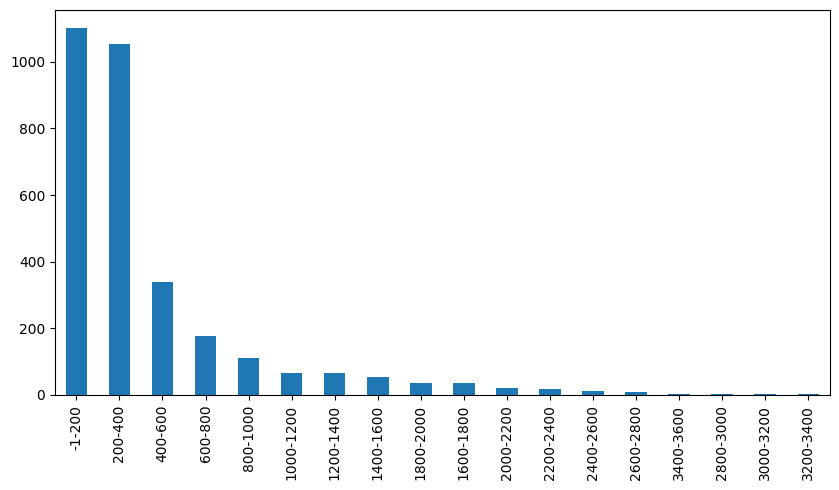

In [54]:
# visualize the elevation group counts
elevation_viz.plot.bar(x='elevation_group', figsize=(10,5))